In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

### Preprocess data

In [2]:
# Import data
path = "../data/petdata_binary_1000_100.csv"
raw_data = pd.read_csv(path, index_col="doc_uri")
assert raw_data.shape == (1000,100), "Import error, df has false shape"

#### Conversion and cleaning
Surprise forces you to use schema \["user_id", "doc_id", "rating"\]

CF models are often sensitive to NA values -> replace NaN with 0 OR drop NaN. For demonstration purpose replacement used.

In [3]:
# Convert df
data = raw_data.unstack().to_frame().reset_index()
data.columns = ["user", "doc_uri", "rating"]

# Missing value handling
data.fillna(0, inplace=True)

assert data.shape == (raw_data.shape[0] * raw_data.shape[1], 3), "Conversion error, df has false shape"
assert data.rating.max() <= 1., "Value error, max rating over upper bound"
assert data.rating.min() >= -1., "Value error, min rating under lower bound"
data.head()

,user,doc_uri,rating
0,Aaron Keith III,http://www.vargas.biz/login.php,0.0
1,Aaron Keith III,http://wallace-walker.info/index/,0.0
2,Aaron Keith III,http://www.jimenez.biz/,0.0
3,Aaron Keith III,http://www.logan.com/about.html,1.0
4,Aaron Keith III,http://cox.org/list/tag/faq.html,0.0


### Descriptive statistics of ratings
Not meaningful <- randomly generated

In [4]:
data.rating.describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
rating,100000.0,0.10561,0.405238,-1.0,0.0,0.0,0.0,1.0


In [5]:
data.rating.value_counts(normalize=True).to_frame().T

,0.0,1.0,-1.0
rating,0.82463,0.14049,0.03488


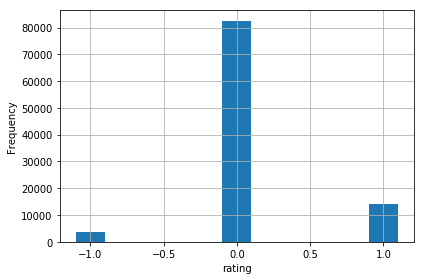

In [6]:
# Plot distribution of (random) ratings 

hist = data.rating.plot(kind="hist", grid=True,
                        bins=[-1.1,-0.9,-0.1,0.1,0.9,1.1])
hist.set(xlabel= "rating")

plt.tight_layout()
plt.savefig("plots/ratings_binary.png", orientation="landscape", dpi=120)

# Recommendation Engines

In [7]:
from surprise import KNNWithMeans, SVD, NMF, Dataset, Reader, accuracy
from surprise.prediction_algorithms.random_pred import NormalPredictor
from surprise.model_selection import cross_validate, GridSearchCV

reader = Reader(rating_scale=(-1, 1))
ds = Dataset.load_from_df(data[["user", "doc_uri", "rating"]], reader)

baseline_model = NormalPredictor() # Baseline model, predicts labels based on distribution of ratings

## Memory-based CF
#### User-based CF

In [8]:
sim_options = {"name": "cosine", # cosine similarity
               "user_based": True,  # user-based
               "min_support": 10 # min number of common items, else pred 0
               }

user_knn = KNNWithMeans(sim_options=sim_options)

#### Item-based CF

In [9]:
sim_options = {"name": "cosine", # cosine similarity
               "user_based": False,  # item-based
               "min_support": 5 # min number of common users, else pred 0
               }

item_knn = KNNWithMeans(sim_options=sim_options)

### Evaluation
Don't expect accurate models <- they are trained with random noise.

User- & item-based CF are slightly better than baseline model (predicts labels based on distribution of ratings). User-based approach works surprisingly better than item-based CF and is faster.

In [10]:
for algo_name, algo in zip(["Baseline", "User-based CF", "Item-based CF"],
                           [baseline_model, user_knn, item_knn]):
    history = cross_validate(algo, ds, measures=["RMSE", "MAE"], cv=5, verbose=False)
    print("***", algo_name, "***")
    print("RMSE: {:0.3f} (std {:0.4f}) <- {}".format(history["test_rmse"].mean(),
                                                     history["test_rmse"].std(),
                                                     history["test_rmse"]))
    print("MAE: {:0.3f} (std {:0.4f}) <- {}".format(history["test_mae"].mean(),
                                                     history["test_mae"].std(),
                                                     history["test_mae"]))
    print("Avg fit time: {:0.5f}s".format(np.array(history["fit_time"]).mean()))

*** Baseline ***
RMSE: 0.567 (std 0.0018) <- [0.56450266 0.56816921 0.56586984 0.56955568 0.56596064]
MAE: 0.436 (std 0.0013) <- [0.43473312 0.43552735 0.43554669 0.43823923 0.434548  ]
Avg fit time: 0.07252s
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
*** User-based CF ***
RMSE: 0.406 (std 0.0030) <- [0.40179204 0.40827718 0.40984483 0.40406852 0.40821968]
MAE: 0.249 (std 0.0021) <- [0.24584902 0.25050721 0.25145895 0.2475609  0.24984724]
Avg fit time: 0.27563s
Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Computing the cosine similari

## Memory-based
Can we enhance performance of model by using memory-based techniques?

#### Matrix factorization-based CF

In [11]:
# Models - tune parameters, if you'd like ;)
svd = SVD() # Singular value decomposition
pmf = SVD(biased=False) # Probabilistic matrix factorization
nmf = NMF() # Non-negative matrix factorization

_Predictions_

SVD:
$\hat r_{ui} = \mu + b_{u} + b_{i} + q^{\mathrm{T}}_{i} p_{u}$

Probabilistic MF:
$\hat r_{ui} = q^{\mathrm{T}}_{i} p_{u}$

Non-negative MF:
$\hat r_{ui} = q^{\mathrm{T}}_{i} p_{u}$ $\mid$ $p_{u}, q_{i} \in \mathbb{R_{+}}$

### Evaluation
Don't expect accurate models <- they are trained with random noise

In [12]:
for algo_name, algo in zip(["SVD", "Probabilistic MF", "Non-negative MF"],
                           [svd, pmf, nmf]):
    history = cross_validate(algo, ds, measures=["RMSE", "MAE"], cv=5, verbose=False)
    print("***", algo_name, "***")
    print("RMSE: {:0.3f} (std {:0.4f}) <- {}".format(history["test_rmse"].mean(),
                                                     history["test_rmse"].std(),
                                                     history["test_rmse"]))
    print("MAE: {:0.3f} (std {:0.4f}) <- {}".format(history["test_mae"].mean(),
                                                     history["test_mae"].std(),
                                                     history["test_mae"]))
    print("Avg fit time: {:0.5f}s".format(np.array(history["fit_time"]).mean()))

*** SVD ***
RMSE: 0.408 (std 0.0032) <- [0.40437288 0.40902001 0.41232286 0.40516453 0.41110122]
MAE: 0.251 (std 0.0021) <- [0.24773542 0.2513486  0.25336075 0.24981911 0.25310767]
Avg fit time: 6.21990s
*** Probabilistic MF ***
RMSE: 0.410 (std 0.0036) <- [0.41719008 0.41094252 0.40795299 0.40895932 0.40724781]
MAE: 0.237 (std 0.0028) <- [0.24236247 0.23708033 0.2347754  0.23594221 0.23515877]
Avg fit time: 6.60087s
*** Non-negative MF ***
RMSE: 0.408 (std 0.0035) <- [0.40750189 0.40287524 0.40837923 0.41373394 0.40721531]
MAE: 0.240 (std 0.0025) <- [0.23950782 0.23640983 0.2402502  0.24409694 0.23976535]
Avg fit time: 6.70569s


Nope, there isn't much of enhancement. But maybe finetuning on the two most promising models helps.

#### Finetuning models
Grid searching the best parameters -> This might take a while, time to brew some XPRESS0 ;)

In [13]:
# SVD
param_svd = {"n_factors": [1, 100],
             "n_epochs": [5, 20],
             "reg_all": [0.02, 0.08], # regularization term for all param
             "lr_all": [0.001, 0.005]} # learning rate for all param

gs_svd = GridSearchCV(SVD, param_svd, measures=["rmse", "mae"], cv=5)
gs_svd.fit(ds)

print("Best RMSE:", gs_svd.best_score["rmse"])
best_params_svd = gs_svd.best_params["rmse"] 
for param in best_params_svd:
    print(param, ":", best_params_svd[param])

Best RMSE: 0.4034754343529513
n_factors : 1
n_epochs : 5
reg_all : 0.08
lr_all : 0.001


In [14]:
# NMF
param_nmf = {"n_factors": [15, 100],
             "n_epochs": [50, 60],
             #"biased": [True, False],
             #"reg_pu": [0.04, 0.06, 0.08], # regularization term for users
             #"reg_qi": [0.04, 0.06, 0.08], # regularization term for items
             "lr_bu": [0.001, 0.005], # learning rate for user bias term
             "lr_bi": [0.001, 0.005]} # learning rate for item bias term

gs_nmf = GridSearchCV(NMF, param_nmf, measures=["rmse"], cv=5)
gs_nmf.fit(ds)

print("Best RMSE:", gs_nmf.best_score["rmse"])
best_params_nmf = gs_nmf.best_params["rmse"] 
for param in best_params_nmf:
    print(param, ":", best_params_nmf[param])

Best RMSE: 0.4061961576389207
n_factors : 100
n_epochs : 60
lr_bu : 0.005
lr_bi : 0.005


# Final model and predictions
SVD looks most promising (but beware that this might change with real-world data). Nevertheless, go with it for the purpose of this demonstration.

#### Train & evaluate final model

In [15]:
# Train final model
trainset = ds.build_full_trainset()

model = gs_svd.best_estimator["rmse"]
model.fit(trainset)


# RMSE of final model
testset = trainset.build_testset()

test_pred = model.test(testset)
accuracy.rmse(test_pred, verbose=True) # should be very bad ;)

RMSE: 0.4015


0.4015159614923071

#### Predict some document ratings

In [20]:
combinations_to_predict = [("Aaron Keith III", "http://www.bell.com/main.php"),
                           ("Linda Torres", "http://www.martin-harris.org/main/"),
                           ("Veronica Jackson", "https://www.carter.com/"),
                           ("Cindy Jones", "https://www.garcia.com/homepage/")]

In [21]:
# Predictions
for combination in combinations_to_predict:
    user = combination[0]
    doc = combination[1]
    pred = model.predict(user, doc)
    pred_string = "like" if pred[3] > 0 else "dislike" # if estimated rating >0 => "like", else "dislike"
    print(pred[0], "should **>", pred_string, "<**", pred[1])

Aaron Keith III should **> like <** http://www.bell.com/main.php
Linda Torres should **> dislike <** http://www.martin-harris.org/main/
Veronica Jackson should **> like <** https://www.carter.com/
Cindy Jones should **> dislike <** https://www.garcia.com/homepage/
